# End-to-End Anomaly Detection Pipeline
## Natural Gas Pipeline Operations Monitoring

**Purpose**: Detect operational anomalies in gas pipeline sensor data from Mardakan, Sumqayit, and Turkan stations.

**Workflow**:
1. Data Loading & Validation
2. Exploratory Data Analysis
3. Preprocessing & Feature Engineering
4. Model Training & Benchmarking (Multiple Algorithms)
5. Model Evaluation & Selection
6. Model Persistence & Results Export

**Directory Structure**:
- `/data` - Raw CSV files
- `/charts` - Visualizations
- `/outputs` - Metrics, tables, summaries
- `/artifacts` - Trained models, scalers, encoders

## 1. Configuration & Setup

In [1]:
# Core imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime
from typing import Dict, List, Tuple, Any

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style (compatible with all matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
sns.set_palette("husl")

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Sklearn - Anomaly Detection Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope

# Sklearn - Metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    classification_report,
    confusion_matrix
)

# Time tracking
import time

print("All imports successful!")

All imports successful!


In [2]:
# ========================
# CONFIGURATION
# ========================

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Directory paths (relative to notebook location)
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
CHARTS_DIR = BASE_DIR / "charts"
OUTPUTS_DIR = BASE_DIR / "outputs"
ARTIFACTS_DIR = BASE_DIR / "artifacts"

# Ensure directories exist
for dir_path in [CHARTS_DIR, OUTPUTS_DIR, ARTIFACTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Data files
DATA_FILES = [
    DATA_DIR / "Mardakan.csv",
    DATA_DIR / "Sumqayit.csv",
    DATA_DIR / "Turkan.csv",
]

# Column mapping (Azerbaijani to English)
COLUMN_RENAME_MAP = {
    "TARİX": "timestamp",
    "XÜSUSİ ÇƏKİ\n(kq/m3)": "density_kg_m3",
    "TƏZYİQLƏR\nFƏRQİ (kPa)": "pressure_diff_kpa",
    "TƏZYİQ (kPa)": "pressure_kpa",
    "TEMPERATUR\n(C)": "temperature_c",
    "SAATLIQ\nSƏRF(min m3)": "hourly_flow_m3",
    "SƏRF (min m3)": "total_flow_m3",
}

# Feature configurations
SENSOR_FEATURES = [
    "density_kg_m3",
    "pressure_diff_kpa",
    "pressure_kpa",
    "temperature_c",
    "hourly_flow_m3",
    "total_flow_m3",
]

TEMPORAL_FEATURES = ["hour", "day_of_week", "month", "year"]

CATEGORICAL_FEATURES = ["location"]

# Model hyperparameters
CONTAMINATION_RATE = 0.01  # Expected anomaly rate (1%)
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print(f"Configuration loaded successfully!")
print(f"Base Directory: {BASE_DIR}")
print(f"Random Seed: {RANDOM_SEED}")
print(f"Contamination Rate: {CONTAMINATION_RATE * 100}%")

Configuration loaded successfully!
Base Directory: /Users/ismatsamadov/crash_detection
Random Seed: 42
Contamination Rate: 1.0%


## 2. Data Loading & Validation

In [3]:
def load_and_tag_csv(file_path: Path) -> pd.DataFrame:
    """
    Load a single CSV file and add location metadata.
    
    Args:
        file_path: Path to CSV file
        
    Returns:
        DataFrame with renamed columns and location tag
    """
    df = pd.read_csv(file_path)
    
    # Rename columns BEFORE concat
    df = df.rename(columns=COLUMN_RENAME_MAP)
    
    # Add location column
    df = df.copy()
    df["location"] = file_path.stem
    
    print(f"✓ Loaded {file_path.name}: {len(df):,} rows")
    
    return df


def combine_location_files(file_paths: List[Path]) -> pd.DataFrame:
    """
    Combine multiple location CSV files into a single DataFrame.
    
    Args:
        file_paths: List of paths to CSV files
        
    Returns:
        Combined DataFrame with validation
    """
    dataframes = []
    total_expected_rows = 0
    
    for path in file_paths:
        df = load_and_tag_csv(path)
        dataframes.append(df)
        total_expected_rows += len(df)
    
    combined_df = pd.concat(
        dataframes,
        axis=0,
        ignore_index=True
    )
    
    print("=" * 60)
    print(f"Expected total rows : {total_expected_rows:,}")
    print(f"Combined DF rows    : {len(combined_df):,}")
    print(
        f"Row loss detected   : {'YES ⚠️' if total_expected_rows != len(combined_df) else 'NO ✓'}"
    )
    
    # Validation
    required_columns = set(COLUMN_RENAME_MAP.values()) | {"location"}
    missing = required_columns - set(combined_df.columns)
    
    if missing:
        raise RuntimeError(f"Missing expected columns: {missing}")
    
    print(f"Schema validation   : PASSED ✓")
    print("=" * 60)
    
    return combined_df


# Load data
print("Loading data files...\n")
df_raw = combine_location_files(DATA_FILES)

print(f"\nFinal columns: {df_raw.columns.tolist()}")
print(f"Unique locations: {df_raw['location'].unique().tolist()}")
print(f"\nDataFrame shape: {df_raw.shape}")

Loading data files...

✓ Loaded Mardakan.csv: 57,978 rows
✓ Loaded Sumqayit.csv: 58,011 rows
✓ Loaded Turkan.csv: 57,978 rows
Expected total rows : 173,967
Combined DF rows    : 173,967
Row loss detected   : NO ✓
Schema validation   : PASSED ✓

Final columns: ['timestamp', 'density_kg_m3', 'pressure_diff_kpa', 'pressure_kpa', 'temperature_c', 'hourly_flow_m3', 'total_flow_m3', 'location']
Unique locations: ['Mardakan', 'Sumqayit', 'Turkan']

DataFrame shape: (173967, 8)


### 2.1 Data Quality Assessment

In [4]:
def assess_data_quality(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate comprehensive data quality report.
    
    Args:
        df: Input DataFrame
        
    Returns:
        Quality report DataFrame
    """
    quality_report = pd.DataFrame({
        'dtype': df.dtypes,
        'non_null_count': df.count(),
        'null_count': df.isnull().sum(),
        'null_pct': (df.isnull().sum() / len(df) * 100).round(2),
        'unique_values': df.nunique(),
        'unique_pct': (df.nunique() / len(df) * 100).round(2),
    })
    
    return quality_report


# Generate quality report
quality_report = assess_data_quality(df_raw)
print("\n📊 DATA QUALITY REPORT")
print("=" * 80)
print(quality_report)

# Save to outputs
quality_report.to_csv(OUTPUTS_DIR / "01_data_quality_report_raw.csv")
print(f"\n✓ Saved quality report to: {OUTPUTS_DIR / '01_data_quality_report_raw.csv'}")

# Summary statistics
total_nulls = df_raw.isnull().sum().sum()
rows_with_nulls = df_raw.isnull().any(axis=1).sum()

print(f"\n📈 Summary:")
print(f"Total null values    : {total_nulls:,}")
print(f"Rows with nulls      : {rows_with_nulls:,} ({rows_with_nulls/len(df_raw)*100:.2f}%)")
print(f"Complete rows        : {len(df_raw) - rows_with_nulls:,}")


📊 DATA QUALITY REPORT
                     dtype  non_null_count  null_count  null_pct  \
timestamp           object          173967           0    0.0000   
density_kg_m3      float64          170289        3678    2.1100   
pressure_diff_kpa  float64          170289        3678    2.1100   
pressure_kpa       float64          170289        3678    2.1100   
temperature_c      float64          170289        3678    2.1100   
hourly_flow_m3     float64          170289        3678    2.1100   
total_flow_m3      float64          170289        3678    2.1100   
location            object          173967           0    0.0000   

                   unique_values  unique_pct  
timestamp                  61855     35.5600  
density_kg_m3               3121      1.7900  
pressure_diff_kpa         115754     66.5400  
pressure_kpa              133663     76.8300  
temperature_c              41878     24.0700  
hourly_flow_m3             30311     17.4200  
total_flow_m3             119453   

### 2.2 Remove Null Values

In [5]:
# Remove rows with any null values
df_clean = df_raw.dropna()

print(f"Rows before cleaning: {len(df_raw):,}")
print(f"Rows after cleaning : {len(df_clean):,}")
print(f"Rows removed        : {len(df_raw) - len(df_clean):,} ({(len(df_raw) - len(df_clean))/len(df_raw)*100:.2f}%)")
print(f"\nNull values remaining: {df_clean.isnull().sum().sum()}")

# Verify no nulls remain
assert df_clean.isnull().sum().sum() == 0, "Null values still present after cleaning!"
print("✓ Data cleaning validated")

Rows before cleaning: 173,967
Rows after cleaning : 170,289
Rows removed        : 3,678 (2.11%)

Null values remaining: 0
✓ Data cleaning validated


## 3. Exploratory Data Analysis

In [6]:
# Convert timestamp to datetime (using dayfirst=True for DD-MM-YYYY format)
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], dayfirst=True, format='mixed')

# Basic statistics
print("📊 DESCRIPTIVE STATISTICS\n")
stats = df_clean[SENSOR_FEATURES].describe()
print(stats)

# Save statistics
stats.to_csv(OUTPUTS_DIR / "02_descriptive_statistics.csv")
print(f"\n✓ Saved statistics to: {OUTPUTS_DIR / '02_descriptive_statistics.csv'}")

📊 DESCRIPTIVE STATISTICS

       density_kg_m3  pressure_diff_kpa  pressure_kpa  temperature_c  \
count    170289.0000        170289.0000   170289.0000    170289.0000   
mean          0.7394             9.2100      485.6506        16.3247   
std           0.0140             8.0300       95.8001        17.3695   
min           0.0000            -0.9840        0.0000       -34.5680   
25%           0.7278             3.1537      411.8400         8.2320   
50%           0.7347             7.3829      487.0770        15.2120   
75%           0.7528            12.8873      561.7440        23.3890   
max           1.0000            69.1320      770.9690       746.1530   

       hourly_flow_m3  total_flow_m3  
count     170289.0000    170289.0000  
mean           8.1903       196.5660  
std           11.3872       273.2937  
min            0.0000         0.0000  
25%            1.0350        24.8500  
50%            4.4610       107.0560  
75%            7.0970       170.3300  
max          

In [7]:
# Distribution by location
location_dist = df_clean['location'].value_counts()
print("\n📍 DISTRIBUTION BY LOCATION")
print(location_dist)

# Time range
print(f"\n📅 TIME RANGE")
print(f"Start: {df_clean['timestamp'].min()}")
print(f"End  : {df_clean['timestamp'].max()}")
print(f"Duration: {(df_clean['timestamp'].max() - df_clean['timestamp'].min()).days} days")


📍 DISTRIBUTION BY LOCATION
location
Mardakan    57327
Sumqayit    56637
Turkan      56325
Name: count, dtype: int64

📅 TIME RANGE
Start: 2018-01-01 01:00:00
End  : 2024-08-21 16:00:00
Duration: 2424 days


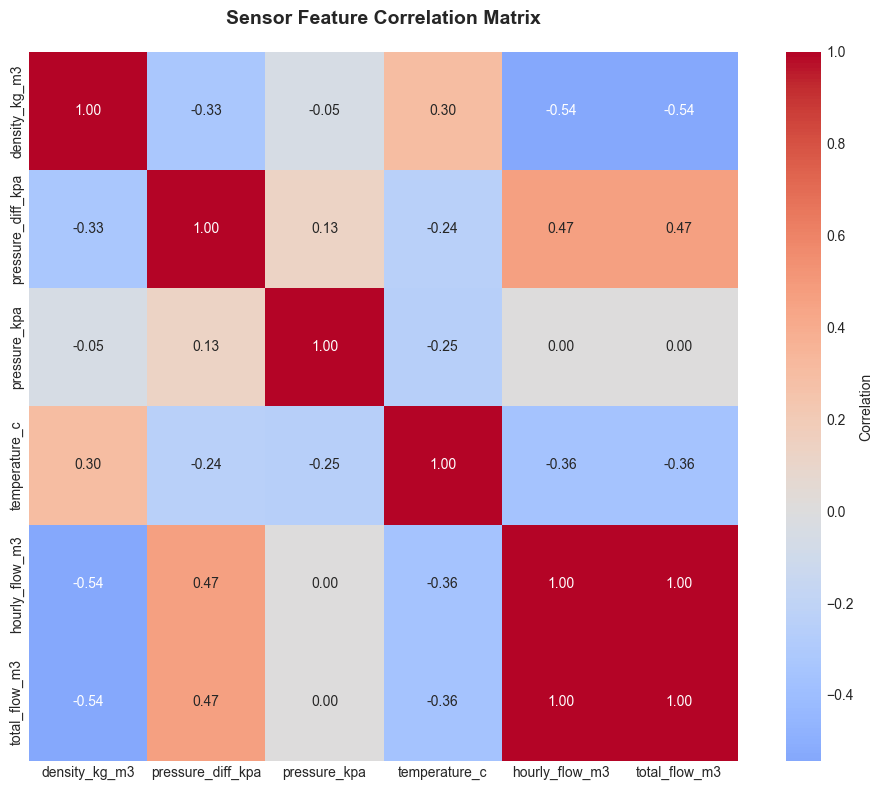

✓ Saved correlation matrix to: /Users/ismatsamadov/crash_detection/charts/01_correlation_matrix.png


In [8]:
# Correlation analysis
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = df_clean[SENSOR_FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Sensor Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(CHARTS_DIR / "01_correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved correlation matrix to: {CHARTS_DIR / '01_correlation_matrix.png'}")

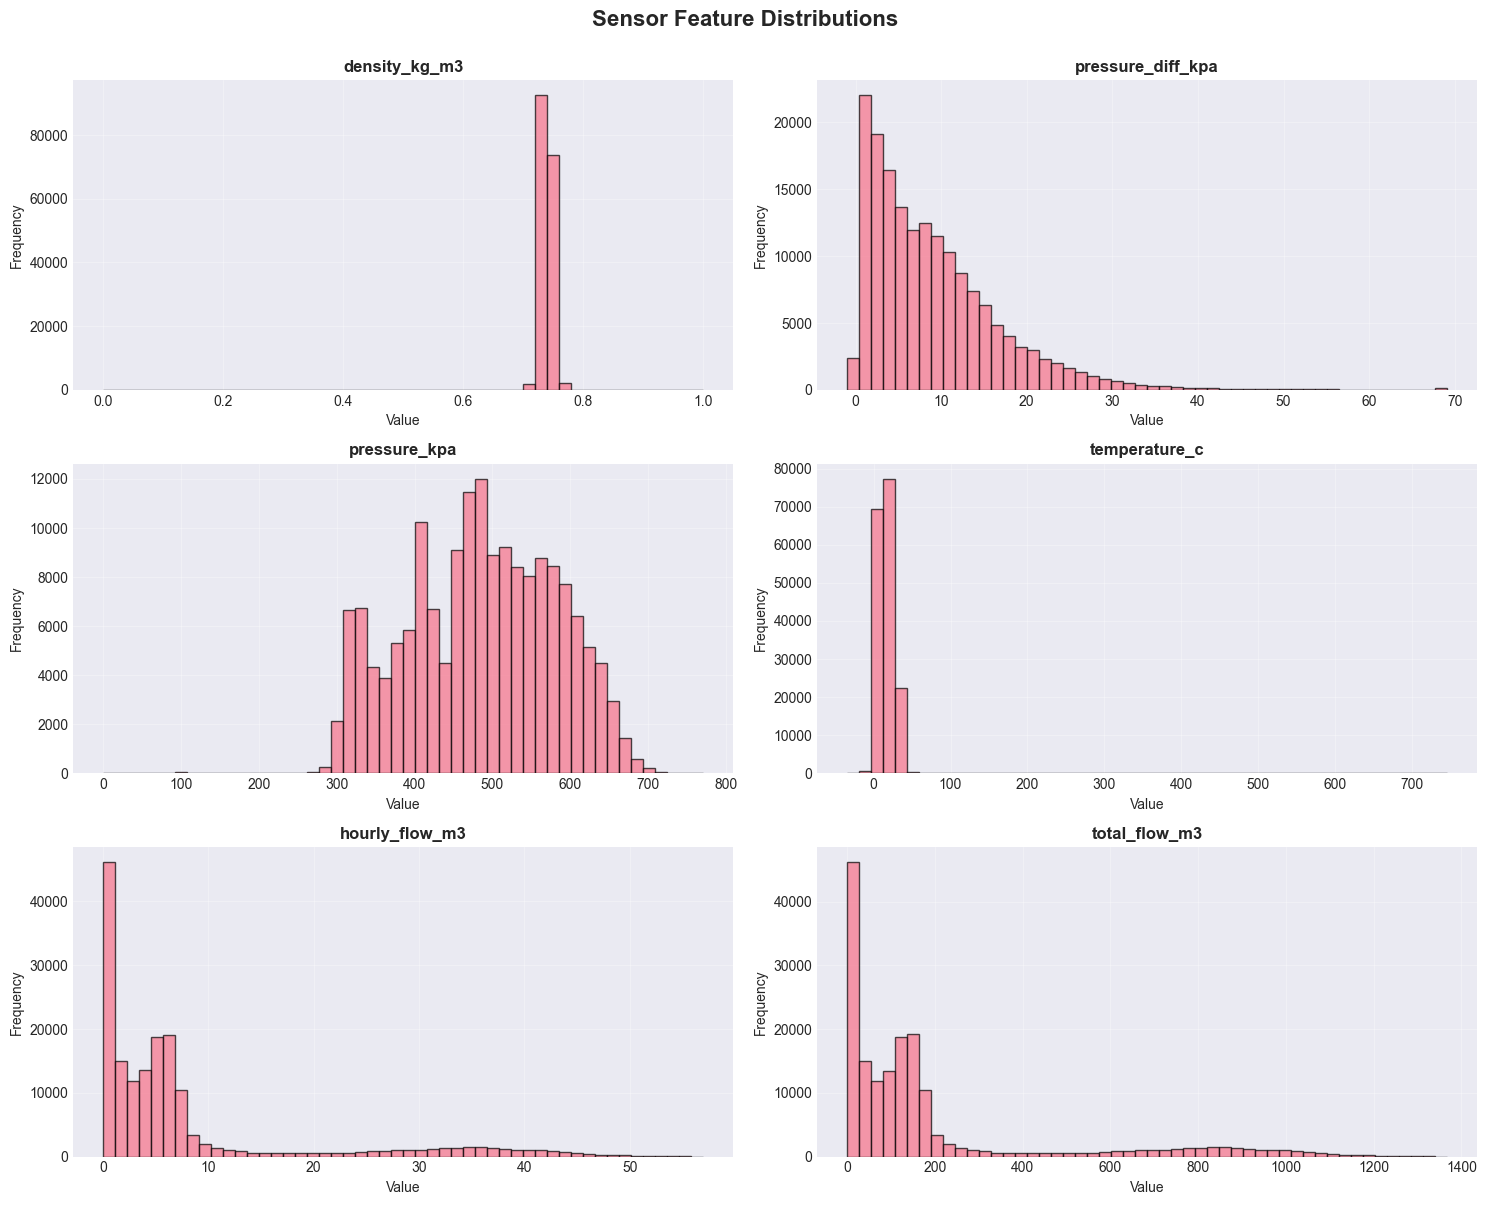

✓ Saved distributions to: /Users/ismatsamadov/crash_detection/charts/02_feature_distributions.png


In [9]:
# Distribution plots for sensor features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(SENSOR_FEATURES):
    axes[idx].hist(df_clean[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Sensor Feature Distributions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(CHARTS_DIR / "02_feature_distributions.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved distributions to: {CHARTS_DIR / '02_feature_distributions.png'}")

## 4. Feature Engineering

In [10]:
def extract_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract temporal features from timestamp column.
    
    Args:
        df: Input DataFrame with 'timestamp' column
        
    Returns:
        DataFrame with additional temporal features
    """
    df = df.copy()
    
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    
    print("✓ Temporal features extracted:")
    print(f"  - hour (0-23)")
    print(f"  - day_of_week (0-6, Monday=0)")
    print(f"  - month (1-12)")
    print(f"  - year")
    
    return df


# Extract temporal features
df_features = extract_temporal_features(df_clean)

# Verify
print(f"\nDataFrame shape after feature engineering: {df_features.shape}")
print(f"New columns: {[col for col in df_features.columns if col not in df_clean.columns]}")

✓ Temporal features extracted:
  - hour (0-23)
  - day_of_week (0-6, Monday=0)
  - month (1-12)
  - year

DataFrame shape after feature engineering: (170289, 12)
New columns: ['hour', 'day_of_week', 'month', 'year']


In [11]:
# One-hot encode location
df_encoded = pd.get_dummies(df_features, columns=['location'], prefix='loc', drop_first=False)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"Location columns: {[col for col in df_encoded.columns if col.startswith('loc_')]}")

Shape after encoding: (170289, 14)
Location columns: ['loc_Mardakan', 'loc_Sumqayit', 'loc_Turkan']


## 5. Data Splitting & Preprocessing Pipeline

In [12]:
# Prepare feature matrix
feature_columns = SENSOR_FEATURES + TEMPORAL_FEATURES + [col for col in df_encoded.columns if col.startswith('loc_')]
X = df_encoded[feature_columns].values

print(f"Feature matrix shape: {X.shape}")
print(f"Total features: {len(feature_columns)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Feature matrix shape: (170289, 13)
Total features: 13

Feature columns:
   1. density_kg_m3
   2. pressure_diff_kpa
   3. pressure_kpa
   4. temperature_c
   5. hourly_flow_m3
   6. total_flow_m3
   7. hour
   8. day_of_week
   9. month
  10. year
  11. loc_Mardakan
  12. loc_Sumqayit
  13. loc_Turkan


In [13]:
# Split data: Train (70%), Validation (10%), Test (20%)
X_temp, X_test = train_test_split(X, test_size=TEST_SIZE, random_state=RANDOM_SEED)
X_train, X_val = train_test_split(X_temp, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=RANDOM_SEED)

print(f"Data split (random_state={RANDOM_SEED}):")
print(f"  Train set: {X_train.shape[0]:>6,} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Val set  : {X_val.shape[0]:>6,} samples ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Test set : {X_test.shape[0]:>6,} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Total    : {X.shape[0]:>6,} samples")

# Verify no data leakage
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Data split mismatch!"
print("\n✓ Data split validated (no leakage)")

Data split (random_state=42):
  Train set: 119,202 samples (70.0%)
  Val set  : 17,029 samples (10.0%)
  Test set : 34,058 samples (20.0%)
  Total    : 170,289 samples

✓ Data split validated (no leakage)


In [14]:
# Fit scaler on training data only (prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ StandardScaler fitted on training data")
print(f"  Mean   : {scaler.mean_[:3]} ... (showing first 3)")
print(f"  Std Dev: {scaler.scale_[:3]} ... (showing first 3)")

# Save scaler
scaler_path = ARTIFACTS_DIR / "scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"\n✓ Saved scaler to: {scaler_path}")

✓ StandardScaler fitted on training data
  Mean   : [  0.73936728   9.21666238 485.75817126] ... (showing first 3)
  Std Dev: [1.40363424e-02 8.06765156e+00 9.57149179e+01] ... (showing first 3)

✓ Saved scaler to: /Users/ismatsamadov/crash_detection/artifacts/scaler.joblib


## 6. Model Development & Benchmarking

We will train and compare the following anomaly detection algorithms:

1. **Isolation Forest** - Tree-based ensemble method
2. **Local Outlier Factor (LOF)** - Density-based local outlier detection
3. **One-Class SVM** - Support vector-based boundary detection
4. **DBSCAN** - Density-based clustering (noise points = anomalies)
5. **Elliptic Envelope** - Robust covariance estimation

In [15]:
def train_and_evaluate_model(model, model_name: str, X_train, X_val, 
                             fit_predict: bool = False) -> Dict[str, Any]:
    """
    Train anomaly detection model and evaluate performance.
    
    Args:
        model: Sklearn anomaly detection model
        model_name: Name of the model for reporting
        X_train: Training data
        X_val: Validation data
        fit_predict: Whether model requires fit_predict (e.g., LOF, DBSCAN)
        
    Returns:
        Dictionary with model, predictions, metrics, and timing
    """
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    # Training
    start_time = time.time()
    
    if fit_predict:
        # Models like LOF and DBSCAN use fit_predict
        y_train_pred = model.fit_predict(X_train)
        y_val_pred = model.fit_predict(X_val)  # Re-fit on validation for these models
    else:
        # Standard fit/predict pattern
        model.fit(X_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    train_time = time.time() - start_time
    
    # Convert predictions to binary (1 = normal, -1 = anomaly)
    # Some models output 0/1, convert to -1/1
    if set(np.unique(y_train_pred)).issubset({0, 1}):
        y_train_pred = np.where(y_train_pred == 0, -1, 1)
        y_val_pred = np.where(y_val_pred == 0, -1, 1)
    
    # Calculate metrics
    train_anomalies = (y_train_pred == -1).sum()
    train_anomaly_rate = train_anomalies / len(y_train_pred) * 100
    
    val_anomalies = (y_val_pred == -1).sum()
    val_anomaly_rate = val_anomalies / len(y_val_pred) * 100
    
    print(f"\n✓ Training completed in {train_time:.2f}s")
    print(f"\nTrain Set:")
    print(f"  Normal    : {(y_train_pred == 1).sum():,} ({100 - train_anomaly_rate:.2f}%)")
    print(f"  Anomalies : {train_anomalies:,} ({train_anomaly_rate:.2f}%)")
    
    print(f"\nValidation Set:")
    print(f"  Normal    : {(y_val_pred == 1).sum():,} ({100 - val_anomaly_rate:.2f}%)")
    print(f"  Anomalies : {val_anomalies:,} ({val_anomaly_rate:.2f}%)")
    
    # Try to get anomaly scores (if available)
    scores_train = None
    scores_val = None
    
    if hasattr(model, 'decision_function'):
        try:
            scores_train = model.decision_function(X_train)
            scores_val = model.decision_function(X_val)
            print(f"\nAnomaly Scores (validation):")
            print(f"  Min  : {scores_val.min():.4f}")
            print(f"  Max  : {scores_val.max():.4f}")
            print(f"  Mean : {scores_val.mean():.4f}")
        except:
            pass
    elif hasattr(model, 'score_samples'):
        try:
            scores_train = model.score_samples(X_train)
            scores_val = model.score_samples(X_val)
            print(f"\nAnomaly Scores (validation):")
            print(f"  Min  : {scores_val.min():.4f}")
            print(f"  Max  : {scores_val.max():.4f}")
            print(f"  Mean : {scores_val.mean():.4f}")
        except:
            pass
    
    return {
        'model': model,
        'model_name': model_name,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'scores_train': scores_train,
        'scores_val': scores_val,
        'train_time': train_time,
        'train_anomaly_rate': train_anomaly_rate,
        'val_anomaly_rate': val_anomaly_rate,
        'train_anomalies': train_anomalies,
        'val_anomalies': val_anomalies,
    }

print("✓ Training and evaluation function defined")

✓ Training and evaluation function defined


### 6.1 Isolation Forest

In [16]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=CONTAMINATION_RATE,
    random_state=RANDOM_SEED,
    max_samples='auto',
    n_jobs=-1,
    verbose=0
)

results_iso = train_and_evaluate_model(
    iso_forest, 
    "Isolation Forest", 
    X_train_scaled, 
    X_val_scaled
)


Training: Isolation Forest



✓ Training completed in 0.85s

Train Set:
  Normal    : 118,009 (99.00%)
  Anomalies : 1,193 (1.00%)

Validation Set:
  Normal    : 16,824 (98.80%)
  Anomalies : 205 (1.20%)



Anomaly Scores (validation):
  Min  : -0.0467
  Max  : 0.1569
  Mean : 0.0895


### 6.2 Local Outlier Factor (LOF)

**Note**: LOF is configured with `novelty=True` to enable production inference. This allows the model to:
- Be trained on normal data
- Predict on new unseen data
- Work seamlessly in pipelines

With `novelty=False`, LOF can only use `fit_predict()` on the same data, making it unsuitable for production.

In [17]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=CONTAMINATION_RATE,
    novelty=True,  # Enable novelty detection for production inference
    n_jobs=-1
)

results_lof = train_and_evaluate_model(
    lof, 
    "Local Outlier Factor", 
    X_train_scaled, 
    X_val_scaled,
    fit_predict=False  # Use standard fit/predict with novelty=True
)


Training: Local Outlier Factor



✓ Training completed in 5.82s

Train Set:
  Normal    : 118,215 (99.17%)
  Anomalies : 987 (0.83%)

Validation Set:
  Normal    : 16,822 (98.78%)
  Anomalies : 207 (1.22%)



Anomaly Scores (validation):
  Min  : -30.3705
  Max  : 0.3619
  Mean : 0.2550


### 6.3 One-Class SVM

In [18]:
one_class_svm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=CONTAMINATION_RATE,  # nu is expected proportion of outliers
)

results_svm = train_and_evaluate_model(
    one_class_svm, 
    "One-Class SVM", 
    X_train_scaled, 
    X_val_scaled
)


Training: One-Class SVM



✓ Training completed in 34.42s

Train Set:
  Normal    : 118,011 (99.00%)
  Anomalies : 1,191 (1.00%)

Validation Set:
  Normal    : 16,856 (98.98%)
  Anomalies : 173 (1.02%)



Anomaly Scores (validation):
  Min  : -84.1019
  Max  : 60.1081
  Mean : 24.5079


### 6.4 DBSCAN

In [19]:
dbscan = DBSCAN(
    eps=0.5,
    min_samples=50,
    n_jobs=-1
)

results_dbscan = train_and_evaluate_model(
    dbscan, 
    "DBSCAN", 
    X_train_scaled, 
    X_val_scaled,
    fit_predict=True
)


Training: DBSCAN



✓ Training completed in 1.44s

Train Set:
  Normal    : 62 (0.19%)
  Anomalies : 118,977 (99.81%)

Validation Set:
  Normal    : 0 (0.00%)
  Anomalies : 17,029 (100.00%)


### 6.5 Elliptic Envelope

In [20]:
elliptic = EllipticEnvelope(
    contamination=CONTAMINATION_RATE,
    random_state=RANDOM_SEED,
    support_fraction=None
)

results_elliptic = train_and_evaluate_model(
    elliptic, 
    "Elliptic Envelope", 
    X_train_scaled, 
    X_val_scaled
)


Training: Elliptic Envelope



✓ Training completed in 2.08s

Train Set:
  Normal    : 118,009 (99.00%)
  Anomalies : 1,193 (1.00%)

Validation Set:
  Normal    : 16,833 (98.85%)
  Anomalies : 196 (1.15%)

Anomaly Scores (validation):
  Min  : -17652.1968
  Max  : 364.3084
  Mean : 318.3042


## 7. Model Comparison & Benchmarking

In [21]:
# Compile all results
all_results = [
    results_iso,
    results_lof,
    results_svm,
    results_dbscan,
    results_elliptic,
]

# Create comparison table
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Model': result['model_name'],
        'Train Time (s)': round(result['train_time'], 3),
        'Train Anomaly Rate (%)': round(result['train_anomaly_rate'], 2),
        'Val Anomaly Rate (%)': round(result['val_anomaly_rate'], 2),
        'Train Anomalies': result['train_anomalies'],
        'Val Anomalies': result['val_anomalies'],
        'Rate Consistency': abs(result['train_anomaly_rate'] - result['val_anomaly_rate']),
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Rate Consistency')

print("\n" + "="*100)
print("MODEL COMPARISON & BENCHMARKING")
print("="*100)
print(comparison_df.to_string(index=False))
print("\nNote: 'Rate Consistency' = absolute difference between train and val anomaly rates")
print("      Lower values indicate more consistent behavior across datasets.")

# Save comparison
comparison_df.to_csv(OUTPUTS_DIR / "03_model_comparison.csv", index=False)
print(f"\n✓ Saved comparison to: {OUTPUTS_DIR / '03_model_comparison.csv'}")


MODEL COMPARISON & BENCHMARKING
               Model  Train Time (s)  Train Anomaly Rate (%)  Val Anomaly Rate (%)  Train Anomalies  Val Anomalies  Rate Consistency
       One-Class SVM         34.4180                  1.0000                1.0200             1191            173            0.0168
   Elliptic Envelope          2.0760                  1.0000                1.1500             1193            196            0.1502
              DBSCAN          1.4360                 99.8100              100.0000           118977          17029            0.1888
    Isolation Forest          0.8520                  1.0000                1.2000             1193            205            0.2030
Local Outlier Factor          5.8180                  0.8300                1.2200              987            207            0.3876

Note: 'Rate Consistency' = absolute difference between train and val anomaly rates
      Lower values indicate more consistent behavior across datasets.

✓ Saved compar

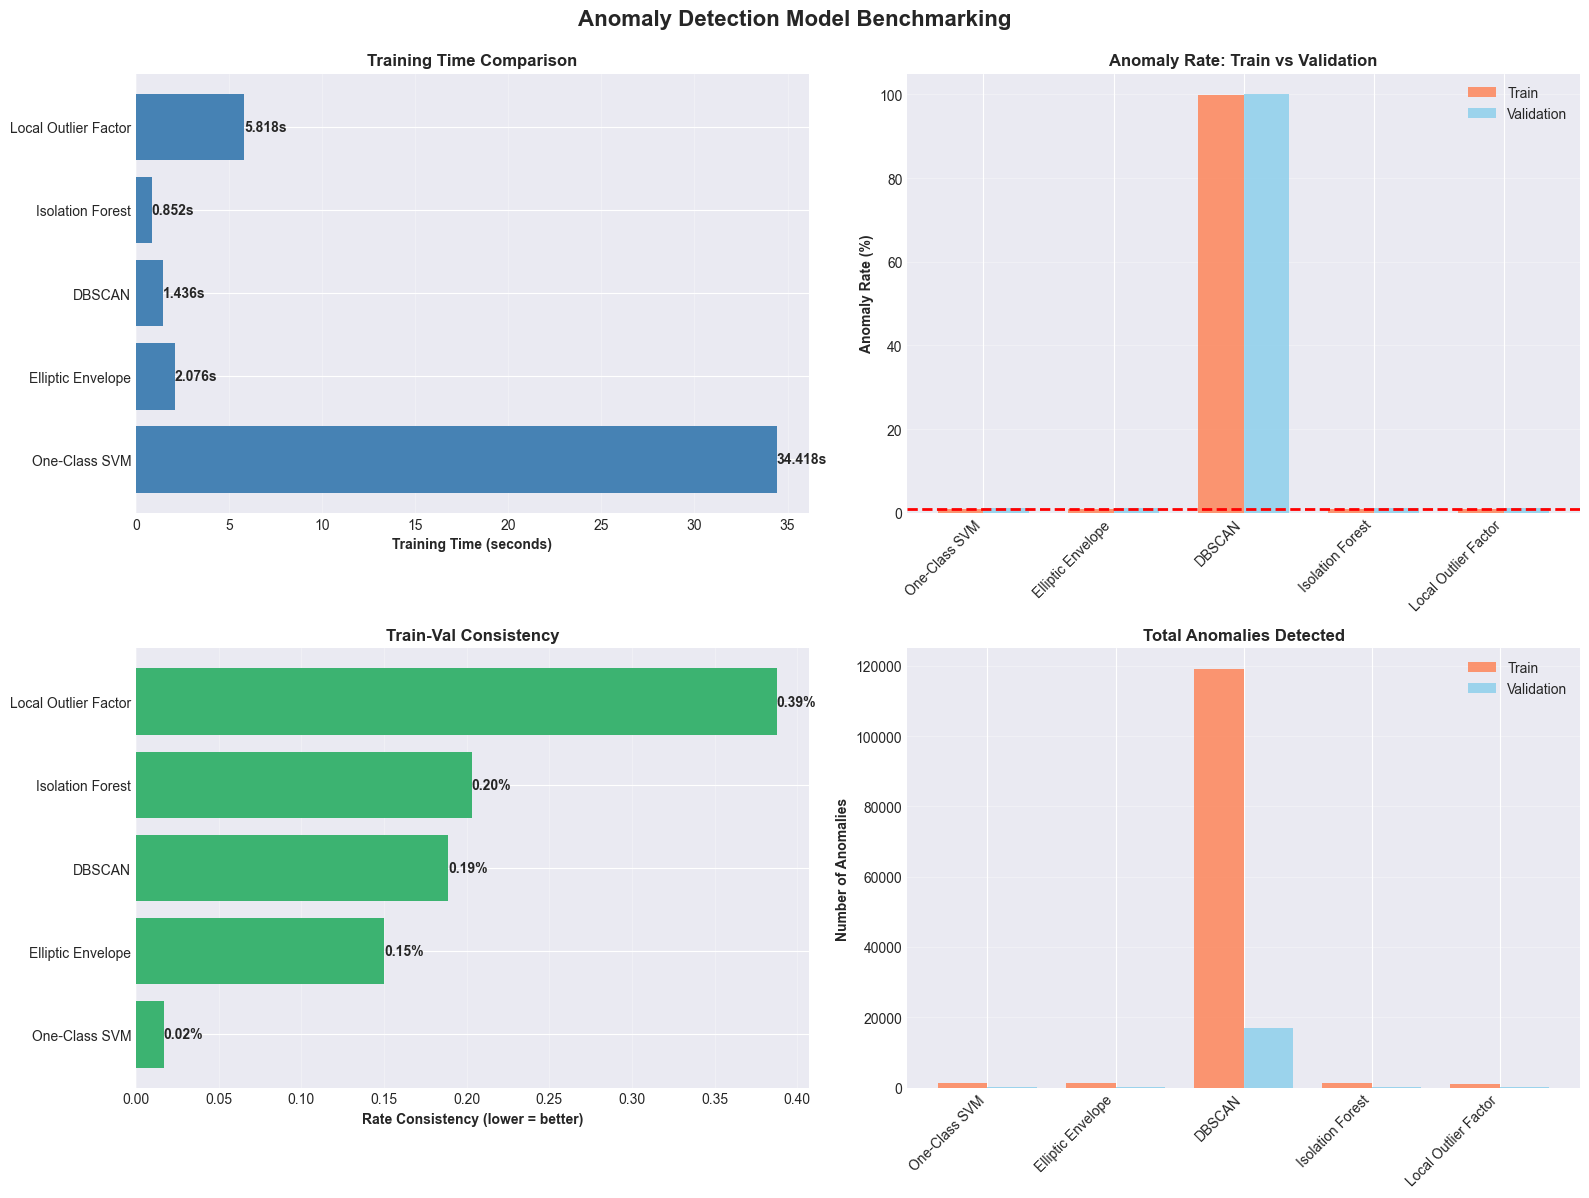

✓ Saved comparison chart to: /Users/ismatsamadov/crash_detection/charts/03_model_comparison.png


In [22]:
# Visualization: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training time comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(comparison_df['Model'], comparison_df['Train Time (s)'], color='steelblue')
ax1.set_xlabel('Training Time (seconds)', fontweight='bold')
ax1.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}s', ha='left', va='center', fontweight='bold')

# 2. Anomaly rate comparison
ax2 = axes[0, 1]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax2.bar(x_pos - width/2, comparison_df['Train Anomaly Rate (%)'], width, 
        label='Train', color='coral', alpha=0.8)
ax2.bar(x_pos + width/2, comparison_df['Val Anomaly Rate (%)'], width, 
        label='Validation', color='skyblue', alpha=0.8)
ax2.set_ylabel('Anomaly Rate (%)', fontweight='bold')
ax2.set_title('Anomaly Rate: Train vs Validation', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=CONTAMINATION_RATE*100, color='red', linestyle='--', 
            label=f'Expected ({CONTAMINATION_RATE*100}%)', linewidth=2)

# 3. Rate consistency
ax3 = axes[1, 0]
bars3 = ax3.barh(comparison_df['Model'], comparison_df['Rate Consistency'], color='mediumseagreen')
ax3.set_xlabel('Rate Consistency (lower = better)', fontweight='bold')
ax3.set_title('Train-Val Consistency', fontweight='bold', fontsize=12)
ax3.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}%', ha='left', va='center', fontweight='bold')

# 4. Total anomalies detected
ax4 = axes[1, 1]
x_pos = np.arange(len(comparison_df))
ax4.bar(x_pos - width/2, comparison_df['Train Anomalies'], width, 
        label='Train', color='coral', alpha=0.8)
ax4.bar(x_pos + width/2, comparison_df['Val Anomalies'], width, 
        label='Validation', color='skyblue', alpha=0.8)
ax4.set_ylabel('Number of Anomalies', fontweight='bold')
ax4.set_title('Total Anomalies Detected', fontweight='bold', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Anomaly Detection Model Benchmarking', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(CHARTS_DIR / "03_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved comparison chart to: {CHARTS_DIR / '03_model_comparison.png'}")

## 8. Select Best Model & Final Evaluation

In [23]:
# Select best model based on rate consistency and expected contamination
best_model_idx = comparison_df['Rate Consistency'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_result = all_results[best_model_idx]

print(f"\n{'='*80}")
print(f"BEST MODEL SELECTED: {best_model_name}")
print(f"{'='*80}")
print(f"\nSelection Criteria:")
print(f"  - Lowest train-val rate consistency: {comparison_df.loc[best_model_idx, 'Rate Consistency']:.2f}%")
print(f"  - Train anomaly rate: {best_result['train_anomaly_rate']:.2f}%")
print(f"  - Val anomaly rate: {best_result['val_anomaly_rate']:.2f}%")
print(f"  - Training time: {best_result['train_time']:.3f}s")


BEST MODEL SELECTED: One-Class SVM

Selection Criteria:
  - Lowest train-val rate consistency: 0.02%
  - Train anomaly rate: 1.00%
  - Val anomaly rate: 1.02%
  - Training time: 34.418s


In [24]:
# Final evaluation on test set
print(f"\n{'='*80}")
print(f"FINAL EVALUATION ON TEST SET")
print(f"{'='*80}")

best_model = best_result['model']

# Predict on test set
if best_model_name == 'DBSCAN':
    # DBSCAN requires fit_predict (clustering-based)
    y_test_pred = best_model.fit_predict(X_test_scaled)
else:
    # Standard models (Isolation Forest, LOF with novelty=True, OneClassSVM, Elliptic Envelope)
    y_test_pred = best_model.predict(X_test_scaled)

# Convert if necessary
if set(np.unique(y_test_pred)).issubset({0, 1}):
    y_test_pred = np.where(y_test_pred == 0, -1, 1)

test_anomalies = (y_test_pred == -1).sum()
test_anomaly_rate = test_anomalies / len(y_test_pred) * 100

print(f"\nTest Set Results ({best_model_name}):")
print(f"  Total samples : {len(y_test_pred):,}")
print(f"  Normal        : {(y_test_pred == 1).sum():,} ({100 - test_anomaly_rate:.2f}%)")
print(f"  Anomalies     : {test_anomalies:,} ({test_anomaly_rate:.2f}%)")

# Get anomaly scores if available
test_scores = None
if hasattr(best_model, 'decision_function'):
    try:
        test_scores = best_model.decision_function(X_test_scaled)
        print(f"\nAnomaly Scores:")
        print(f"  Min  : {test_scores.min():.4f}")
        print(f"  Max  : {test_scores.max():.4f}")
        print(f"  Mean : {test_scores.mean():.4f}")
        print(f"  Std  : {test_scores.std():.4f}")
    except:
        pass
elif hasattr(best_model, 'score_samples'):
    try:
        test_scores = best_model.score_samples(X_test_scaled)
        print(f"\nAnomaly Scores:")
        print(f"  Min  : {test_scores.min():.4f}")
        print(f"  Max  : {test_scores.max():.4f}")
        print(f"  Mean : {test_scores.mean():.4f}")
        print(f"  Std  : {test_scores.std():.4f}")
    except:
        pass


FINAL EVALUATION ON TEST SET



Test Set Results (One-Class SVM):
  Total samples : 34,058
  Normal        : 33,733 (99.05%)
  Anomalies     : 325 (0.95%)



Anomaly Scores:
  Min  : -84.7112
  Max  : 62.8185
  Mean : 24.5112
  Std  : 11.0533


## 9. Generate Comprehensive Results

In [25]:
# Create full dataset predictions using best model
print("Generating predictions on full dataset...")

# Scale full dataset
X_full_scaled = scaler.transform(X)

# Predict
if best_model_name == 'DBSCAN':
    # DBSCAN requires fit_predict (clustering-based)
    y_full_pred = best_model.fit_predict(X_full_scaled)
else:
    # Standard models: Isolation Forest, LOF (novelty=True), OneClassSVM, Elliptic Envelope
    # Re-fit on full dataset for production model
    best_model.fit(X_full_scaled)
    y_full_pred = best_model.predict(X_full_scaled)

# Convert if necessary
if set(np.unique(y_full_pred)).issubset({0, 1}):
    y_full_pred = np.where(y_full_pred == 0, -1, 1)

# Get scores
full_scores = None
if hasattr(best_model, 'decision_function'):
    try:
        full_scores = best_model.decision_function(X_full_scaled)
    except:
        full_scores = np.zeros(len(y_full_pred))  # Placeholder
elif hasattr(best_model, 'score_samples'):
    try:
        full_scores = best_model.score_samples(X_full_scaled)
    except:
        full_scores = np.zeros(len(y_full_pred))  # Placeholder
else:
    full_scores = np.zeros(len(y_full_pred))  # Placeholder

print(f"✓ Generated {len(y_full_pred):,} predictions")
print(f"  Anomalies detected: {(y_full_pred == -1).sum():,} ({(y_full_pred == -1).sum()/len(y_full_pred)*100:.2f}%)")

Generating predictions on full dataset...


✓ Generated 170,289 predictions
  Anomalies detected: 1,705 (1.00%)


In [26]:
# Create results DataFrame
results_df = df_encoded.copy()
results_df['prediction'] = y_full_pred
results_df['anomaly_score'] = full_scores
results_df['is_anomaly'] = (y_full_pred == -1).astype(int)

# Save results
results_csv_path = OUTPUTS_DIR / "04_anomaly_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"✓ Saved results to: {results_csv_path}")

# Save as JSON
results_json_path = OUTPUTS_DIR / "04_anomaly_results.json"
results_df.to_json(results_json_path, orient='records', indent=2)
print(f"✓ Saved results to: {results_json_path}")

print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Columns: {results_df.columns.tolist()}")

✓ Saved results to: /Users/ismatsamadov/crash_detection/outputs/04_anomaly_results.csv
✓ Saved results to: /Users/ismatsamadov/crash_detection/outputs/04_anomaly_results.json

Results DataFrame shape: (170289, 17)
Columns: ['timestamp', 'density_kg_m3', 'pressure_diff_kpa', 'pressure_kpa', 'temperature_c', 'hourly_flow_m3', 'total_flow_m3', 'hour', 'day_of_week', 'month', 'year', 'loc_Mardakan', 'loc_Sumqayit', 'loc_Turkan', 'prediction', 'anomaly_score', 'is_anomaly']


## 10. Results Analysis & Visualization

In [27]:
# Anomaly distribution by location
# Reverse one-hot encoding to get location names
location_cols = [col for col in results_df.columns if col.startswith('loc_')]
results_df['location_decoded'] = results_df[location_cols].idxmax(axis=1).str.replace('loc_', '')

anomaly_by_location = results_df.groupby('location_decoded')['is_anomaly'].agg(['sum', 'count', 'mean'])
anomaly_by_location.columns = ['Anomalies', 'Total', 'Anomaly_Rate']
anomaly_by_location['Anomaly_Rate'] = anomaly_by_location['Anomaly_Rate'] * 100
anomaly_by_location['Normal'] = anomaly_by_location['Total'] - anomaly_by_location['Anomalies']

print("\n📍 ANOMALY DISTRIBUTION BY LOCATION")
print("="*70)
print(anomaly_by_location)

# Save
anomaly_by_location.to_csv(OUTPUTS_DIR / "05_anomalies_by_location.csv")
print(f"\n✓ Saved location analysis to: {OUTPUTS_DIR / '05_anomalies_by_location.csv'}")


📍 ANOMALY DISTRIBUTION BY LOCATION
                  Anomalies  Total  Anomaly_Rate  Normal
location_decoded                                        
Mardakan                474  57327        0.8268   56853
Sumqayit                738  56637        1.3030   55899
Turkan                  493  56325        0.8753   55832

✓ Saved location analysis to: /Users/ismatsamadov/crash_detection/outputs/05_anomalies_by_location.csv


In [28]:
# Temporal analysis
anomaly_by_hour = results_df.groupby('hour')['is_anomaly'].agg(['sum', 'count', 'mean'])
anomaly_by_hour.columns = ['Anomalies', 'Total', 'Anomaly_Rate']
anomaly_by_hour['Anomaly_Rate'] = anomaly_by_hour['Anomaly_Rate'] * 100

print("\n⏰ ANOMALY DISTRIBUTION BY HOUR")
print("="*70)
print(anomaly_by_hour)

# Save
anomaly_by_hour.to_csv(OUTPUTS_DIR / "06_anomalies_by_hour.csv")
print(f"\n✓ Saved hour analysis to: {OUTPUTS_DIR / '06_anomalies_by_hour.csv'}")


⏰ ANOMALY DISTRIBUTION BY HOUR
      Anomalies  Total  Anomaly_Rate
hour                                
0           273   6562        4.1603
1           145   7247        2.0008
2            66   7248        0.9106
3            38   6818        0.5573
4            34   7246        0.4692
5            24   7150        0.3357
6            14   7241        0.1933
7            18   6803        0.2646
8            26   7225        0.3599
9            22   7234        0.3041
10           26   6616        0.3930
11           30   7090        0.4231
12           46   7248        0.6347
13           48   7248        0.6623
14           52   7249        0.7173
15           49   7236        0.6772
16           43   7219        0.5957
17           33   7210        0.4577
18           41   6982        0.5872
19           55   7249        0.7587
20           76   6460        1.1765
21          117   7224        1.6196
22          157   7249        2.1658
23          272   7235        3.7595

✓ Sav

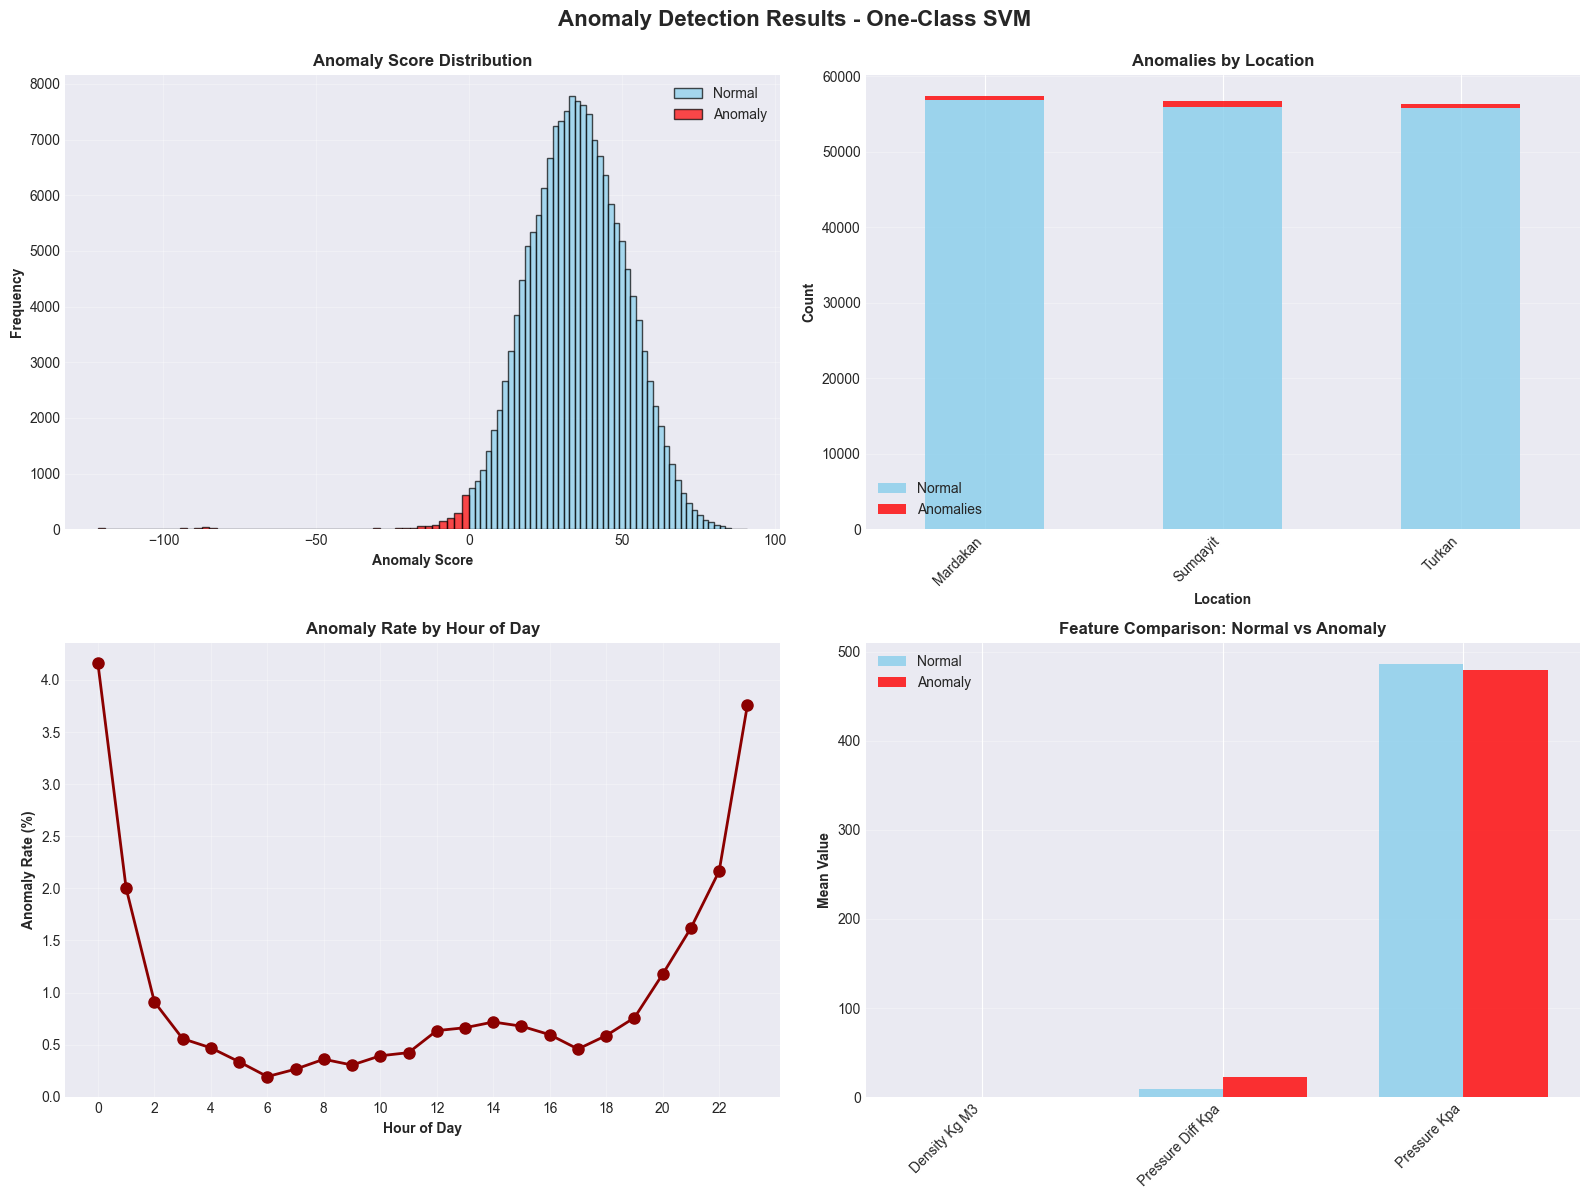

✓ Saved analysis charts to: /Users/ismatsamadov/crash_detection/charts/04_anomaly_analysis.png


In [29]:
# Visualization: Anomaly score distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Score distribution
ax1 = axes[0, 0]
ax1.hist(full_scores[y_full_pred == 1], bins=50, alpha=0.7, label='Normal', color='skyblue', edgecolor='black')
ax1.hist(full_scores[y_full_pred == -1], bins=50, alpha=0.7, label='Anomaly', color='red', edgecolor='black')
ax1.set_xlabel('Anomaly Score', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Anomaly Score Distribution', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Anomalies by location
ax2 = axes[0, 1]
anomaly_by_location[['Normal', 'Anomalies']].plot(kind='bar', stacked=True, ax=ax2, 
                                                    color=['skyblue', 'red'], alpha=0.8)
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Anomalies by Location', fontweight='bold', fontsize=12)
ax2.set_xlabel('Location', fontweight='bold')
ax2.legend(['Normal', 'Anomalies'])
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Anomalies by hour
ax3 = axes[1, 0]
ax3.plot(anomaly_by_hour.index, anomaly_by_hour['Anomaly_Rate'], marker='o', 
         linewidth=2, markersize=8, color='darkred')
ax3.set_xlabel('Hour of Day', fontweight='bold')
ax3.set_ylabel('Anomaly Rate (%)', fontweight='bold')
ax3.set_title('Anomaly Rate by Hour of Day', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)
ax3.set_xticks(range(0, 24, 2))

# 4. Feature comparison (anomaly vs normal)
ax4 = axes[1, 1]
normal_data = results_df[results_df['prediction'] == 1][SENSOR_FEATURES[:3]].mean()
anomaly_data = results_df[results_df['prediction'] == -1][SENSOR_FEATURES[:3]].mean()

x_pos = np.arange(len(SENSOR_FEATURES[:3]))
width = 0.35
ax4.bar(x_pos - width/2, normal_data, width, label='Normal', color='skyblue', alpha=0.8)
ax4.bar(x_pos + width/2, anomaly_data, width, label='Anomaly', color='red', alpha=0.8)
ax4.set_ylabel('Mean Value', fontweight='bold')
ax4.set_title('Feature Comparison: Normal vs Anomaly', fontweight='bold', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f.replace('_', ' ').title() for f in SENSOR_FEATURES[:3]], 
                     rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle(f'Anomaly Detection Results - {best_model_name}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(CHARTS_DIR / "04_anomaly_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved analysis charts to: {CHARTS_DIR / '04_anomaly_analysis.png'}")

## 11. Model Persistence

In [30]:
# Save best model
best_model_path = ARTIFACTS_DIR / f"best_model_{best_model_name.lower().replace(' ', '_').replace('-', '_')}.joblib"
joblib.dump(best_model, best_model_path)
print(f"✓ Saved best model to: {best_model_path}")

# Save feature column names
feature_config = {
    'feature_columns': feature_columns,
    'sensor_features': SENSOR_FEATURES,
    'temporal_features': TEMPORAL_FEATURES,
    'n_features': len(feature_columns),
    'best_model_name': best_model_name,
    'contamination_rate': CONTAMINATION_RATE,
    'random_seed': RANDOM_SEED,
}

feature_config_path = ARTIFACTS_DIR / "feature_config.json"
with open(feature_config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f"✓ Saved feature config to: {feature_config_path}")

# Create production pipeline
production_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', best_model)
])

pipeline_path = ARTIFACTS_DIR / "production_pipeline.joblib"
joblib.dump(production_pipeline, pipeline_path)
print(f"✓ Saved production pipeline to: {pipeline_path}")

print(f"\n{'='*80}")
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print(f"{'='*80}")

✓ Saved best model to: /Users/ismatsamadov/crash_detection/artifacts/best_model_one_class_svm.joblib
✓ Saved feature config to: /Users/ismatsamadov/crash_detection/artifacts/feature_config.json
✓ Saved production pipeline to: /Users/ismatsamadov/crash_detection/artifacts/production_pipeline.joblib

ALL ARTIFACTS SAVED SUCCESSFULLY


## 12. Summary Report

In [31]:
summary_report = f"""
{'='*80}
ANOMALY DETECTION PIPELINE - SUMMARY REPORT
{'='*80}

PROJECT: Natural Gas Pipeline Operations Monitoring
DATE: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
DATA SUMMARY
{'='*80}
Total Records (Raw)      : {len(df_raw):,}
Records After Cleaning   : {len(df_clean):,}
Records Removed          : {len(df_raw) - len(df_clean):,} ({(len(df_raw) - len(df_clean))/len(df_raw)*100:.2f}%)
Locations                : {', '.join(df_clean['location'].unique())}
Time Range               : {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}
Duration                 : {(df_clean['timestamp'].max() - df_clean['timestamp'].min()).days} days

{'='*80}
FEATURE ENGINEERING
{'='*80}
Sensor Features          : {len(SENSOR_FEATURES)}
Temporal Features        : {len(TEMPORAL_FEATURES)}
Location Features        : {len([col for col in feature_columns if col.startswith('loc_')])}
Total Features           : {len(feature_columns)}

{'='*80}
MODEL TRAINING
{'='*80}
Models Evaluated         : {len(all_results)}
Best Model               : {best_model_name}
Selection Criterion      : Lowest train-val rate consistency

Train Set Size           : {X_train.shape[0]:,} ({X_train.shape[0]/X.shape[0]*100:.1f}%)
Validation Set Size      : {X_val.shape[0]:,} ({X_val.shape[0]/X.shape[0]*100:.1f}%)
Test Set Size            : {X_test.shape[0]:,} ({X_test.shape[0]/X.shape[0]*100:.1f}%)

{'='*80}
BEST MODEL PERFORMANCE ({best_model_name})
{'='*80}
Training Time            : {best_result['train_time']:.3f}s
Train Anomaly Rate       : {best_result['train_anomaly_rate']:.2f}%
Val Anomaly Rate         : {best_result['val_anomaly_rate']:.2f}%
Test Anomaly Rate        : {test_anomaly_rate:.2f}%
Rate Consistency         : {comparison_df.loc[best_model_idx, 'Rate Consistency']:.2f}%

{'='*80}
FINAL RESULTS (Full Dataset)
{'='*80}
Total Predictions        : {len(y_full_pred):,}
Normal Observations      : {(y_full_pred == 1).sum():,} ({(y_full_pred == 1).sum()/len(y_full_pred)*100:.2f}%)
Anomalies Detected       : {(y_full_pred == -1).sum():,} ({(y_full_pred == -1).sum()/len(y_full_pred)*100:.2f}%)

Top Anomalous Location   : {anomaly_by_location['Anomaly_Rate'].idxmax()}
Location Anomaly Rate    : {anomaly_by_location['Anomaly_Rate'].max():.2f}%

Peak Anomaly Hour        : {anomaly_by_hour['Anomaly_Rate'].idxmax()}:00
Peak Hour Anomaly Rate   : {anomaly_by_hour['Anomaly_Rate'].max():.2f}%

{'='*80}
OUTPUT FILES
{'='*80}

CHARTS (PNG):
  ✓ {CHARTS_DIR / '01_correlation_matrix.png'}
  ✓ {CHARTS_DIR / '02_feature_distributions.png'}
  ✓ {CHARTS_DIR / '03_model_comparison.png'}
  ✓ {CHARTS_DIR / '04_anomaly_analysis.png'}

OUTPUTS (CSV/JSON):
  ✓ {OUTPUTS_DIR / '01_data_quality_report_raw.csv'}
  ✓ {OUTPUTS_DIR / '02_descriptive_statistics.csv'}
  ✓ {OUTPUTS_DIR / '03_model_comparison.csv'}
  ✓ {OUTPUTS_DIR / '04_anomaly_results.csv'}
  ✓ {OUTPUTS_DIR / '04_anomaly_results.json'}
  ✓ {OUTPUTS_DIR / '05_anomalies_by_location.csv'}
  ✓ {OUTPUTS_DIR / '06_anomalies_by_hour.csv'}

ARTIFACTS (Model Files):
  ✓ {ARTIFACTS_DIR / 'scaler.joblib'}
  ✓ {best_model_path}
  ✓ {ARTIFACTS_DIR / 'feature_config.json'}
  ✓ {ARTIFACTS_DIR / 'production_pipeline.joblib'}

{'='*80}
CONFIGURATION
{'='*80}
Random Seed              : {RANDOM_SEED}
Expected Contamination   : {CONTAMINATION_RATE * 100}%
Test Size                : {TEST_SIZE * 100}%
Validation Size          : {VAL_SIZE * 100}%

{'='*80}
REPRODUCIBILITY
{'='*80}
All random seeds are fixed at {RANDOM_SEED} for full reproducibility.
To reproduce results:
  1. Load data from /data directory
  2. Run this notebook from top to bottom
  3. All outputs will be regenerated identically

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save summary report
summary_path = OUTPUTS_DIR / "00_SUMMARY_REPORT.txt"
with open(summary_path, 'w') as f:
    f.write(summary_report)
print(f"\n✓ Saved summary report to: {summary_path}")


ANOMALY DETECTION PIPELINE - SUMMARY REPORT

PROJECT: Natural Gas Pipeline Operations Monitoring
DATE: 2026-01-24 22:44:18

DATA SUMMARY
Total Records (Raw)      : 173,967
Records After Cleaning   : 170,289
Records Removed          : 3,678 (2.11%)
Locations                : Mardakan, Sumqayit, Turkan
Time Range               : 2018-01-01 01:00:00 to 2024-08-21 16:00:00
Duration                 : 2424 days

FEATURE ENGINEERING
Sensor Features          : 6
Temporal Features        : 4
Location Features        : 3
Total Features           : 13

MODEL TRAINING
Models Evaluated         : 5
Best Model               : One-Class SVM
Selection Criterion      : Lowest train-val rate consistency

Train Set Size           : 119,202 (70.0%)
Validation Set Size      : 17,029 (10.0%)
Test Set Size            : 34,058 (20.0%)

BEST MODEL PERFORMANCE (One-Class SVM)
Training Time            : 34.418s
Train Anomaly Rate       : 1.00%
Val Anomaly Rate         : 1.02%
Test Anomaly Rate        : 0.95%
Rat

## 13. Production Inference Example

In [32]:
# Example: How to use the production pipeline for inference
print("="*80)
print("PRODUCTION INFERENCE EXAMPLE")
print("="*80)

# Load production pipeline
loaded_pipeline = joblib.load(ARTIFACTS_DIR / "production_pipeline.joblib")
loaded_config = json.load(open(ARTIFACTS_DIR / "feature_config.json"))

print("\n✓ Loaded production pipeline and config")
print(f"  Model: {loaded_config['best_model_name']}")
print(f"  Features: {loaded_config['n_features']}")

# Simulate new data (first 5 rows from test set)
new_data = X_test[:5]
print(f"\nSimulating {len(new_data)} new samples...")

# Make predictions
if loaded_config['best_model_name'] == 'DBSCAN':
    # DBSCAN needs special handling (clustering-based, not production-ready)
    print("⚠️  Note: DBSCAN requires retraining for new predictions (not ideal for production).")
    print("    Consider using Isolation Forest or OneClassSVM for production deployment.")
    predictions = loaded_pipeline.named_steps['model'].fit_predict(new_data)
else:
    # Standard predict for production-ready models
    predictions = loaded_pipeline.predict(new_data)

# Display results
print("\nPredictions:")
for i, pred in enumerate(predictions, 1):
    label = "ANOMALY" if pred == -1 else "NORMAL"
    print(f"  Sample {i}: {label}")

print("\n" + "="*80)
print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY")
print("="*80)

PRODUCTION INFERENCE EXAMPLE

✓ Loaded production pipeline and config
  Model: One-Class SVM
  Features: 13

Simulating 5 new samples...

Predictions:
  Sample 1: NORMAL
  Sample 2: NORMAL
  Sample 3: NORMAL
  Sample 4: NORMAL
  Sample 5: NORMAL

PIPELINE EXECUTION COMPLETED SUCCESSFULLY
